### Imports

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# Make required imports
import os
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cat, reshape, sigmoid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader 

Mounted at /content/gdrive


### GPU check

In [2]:
if torch.cuda.is_available() is True:
    print("Current device: {}".format(torch.cuda.current_device()))
    print("Cuda device: {}".format(torch.cuda.device(0)))
    print("Device count: {}".format(torch.cuda.device_count()))
    print("Device name: {}".format(torch.cuda.get_device_name(0)))
else:
    print("GPU not being used. Please connect GPU!")

Current device: 0
Cuda device: <torch.cuda.device object at 0x7fb4b1c67e90>
Device count: 1
Device name: Tesla T4


### Python Code for CameraSensitivityPCA.m

In [3]:
def CameraSensitivityPCA(rgbCMF):
    X = np.zeros((99,28))
    Y = np.zeros((99,28))

    redS = rgbCMF[0,0]
    greenS = rgbCMF[0,1]
    blueS = rgbCMF[0,2]
    
    for i in range(0,28):
        Y[0:33, i] = np.divide(redS[:, i], np.sum(redS[:, i]))
        Y[33:66, i] = np.divide(greenS[:, i], np.sum(greenS[:, i]))
        Y[66:99, i] = np.divide(blueS[:, i], np.sum(blueS[:, i]))
    
    
    pca = PCA(n_components=2)
    # coeff
    PC = pca.fit_transform(Y)
    # latent
    EV = pca.components_
    # mu
    mu = np.mean(Y, axis = 1, keepdims=True)

    PC = torch.from_numpy(np.dot(PC[:, 0:2], np.diag(np.sqrt(EV[:, 0]))))  
    mu = torch.from_numpy(mu)
    EV = torch.from_numpy(EV[:, 0:1])

    return mu, PC, EV 

### Python Code for setup.m

In [4]:
""" This script configures the necessary library, load and prepare the data used in the experimentserver = true; """

folder_path = '/content/gdrive/MyDrive/Colab Notebooks/VMG/utils'

file_name = 'illF.mat'
annots = loadmat('{}/{}'.format(folder_path, file_name))
illF = torch.from_numpy(annots['illF'])

file_name = 'rgbCMF.mat'
annots = loadmat('{}/{}'.format(folder_path, file_name))
rgbCMF = annots['rgbCMF']

file_name = 'illumA.mat'
annots = loadmat('{}/{}'.format(folder_path, file_name))
illumA = torch.from_numpy(annots['illumA'])

file_name = 'illumDmeasured.mat'
annots = loadmat('{}/{}'.format(folder_path, file_name))
illumDmeasured = torch.from_numpy(annots['illumDmeasured'])

file_name = 'Newskincolour.mat'
annots = loadmat('{}/{}'.format(folder_path, file_name))
Newskincolour = torch.from_numpy(annots['Newskincolour'])

file_name = 'Tmatrix.mat'
annots = loadmat('{}/{}'.format(folder_path, file_name))
Tmatrix = torch.from_numpy(annots['Tmatrix'])

nimages = 50765
batchSize= 64

# PCA model for camera sensitivities
[mu, PC, EVpca] = CameraSensitivityPCA(rgbCMF)

# predicted vectors sizes
LightVectorSize = 15  # 15 paramters of light model

wavelength = 33
bSize = 2  # 2 parameters of camera model

# normalise illuminations
illF           = torch.reshape(illF,(1, 1, 33, 12))
illumDmeasured = illumDmeasured.T
illumDmeasured = torch.reshape(illumDmeasured, (1, 1, 33, 22))
# A
illumA         = torch.div(illumA, torch.sum(illumA[:]))
# D
illumDNorm = torch.zeros((1, 1, 33, 22))
for i in range(0,22):
    illumDNorm[0, 0, :, i] = torch.div(illumDmeasured[0, 0, :, i], torch.sum(illumDmeasured[0, 0, :, i]))
  
# F
illumFNorm = torch.zeros((1, 1, 33, 12))
for i in range(0,12):
    illumFNorm[0, 0, :, i] = torch.div(illF[0, 0, :, i], torch.sum(illF[0, 0, :, i]))
 

### Python Code for CNN.m

In [5]:
class CNN_Net(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

        # Add layers
        self.CNN_Net_list = []
        # FC 1
        self.CNN_Net_list.append(nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(4, 4),
                                stride=(1, 1),
                                padding=0))

        self.CNN_Net_list.append(nn.BatchNorm2d(num_features = 512))
        self.CNN_Net_list.append(nn.ReLU())
        # FC2
        self.CNN_Net_list.append(nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0))
        self.CNN_Net_list.append(nn.BatchNorm2d(num_features = 512))
        self.CNN_Net_list.append(nn.ReLU())
        # FC3
        self.CNN_Net_list.append(nn.Conv2d(in_channels=512,
                                out_channels=self.dims,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0))
        # Add layers in ModuleList
        self.layers = nn.ModuleList(self.CNN_Net_list)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x        

In [6]:
def CNN(images,nfilters,nclass,LightVectorSize,bSize):
    """
    Inputs:                                          
        images           : input to CNN
        nfilters         : vector of filter sizes
        nclass           : number of output maps
        lightVectorLSize : 15
        bsize            : 2
    Output:
        weightA    : 1 x 1 x 1 x B
        weightD    : 1 x 1 x 1 x B
        CCT        : 1 x 1 x 1 x B
        Fweights   : 1 x 1 x 12 x B
        b          : 2 x nbatch
    """
    #-------------------------------- CNN -------------------------------------
    print('Process: fcn_multipleDecoders ...')
    [ x,y ] = fcn_multipleDecoders(nfilters, images, nclass, True)
    print('Done ...')
    #---------------------  Fully connected layers --------------------------
    print('Process: CNN_Net ...')
    dims = LightVectorSize + bSize
    cnn_net = CNN_Net(dims)
    prediction = cnn_net.forward(y)
    print('Done ...')
    #--------------------- Illumination parameters --------------------------
    print('Process: Getting parameters and predicted maps ...')
    lightingparameters = prediction[:, 0:LightVectorSize, :, :]
    #------------------------ Camera parameters -----------------------------
    nbatch = prediction.shape[0]
    b = reshape(prediction[:, LightVectorSize:LightVectorSize+bSize, :, :],(bSize, nbatch)) 
    
    #------------------------- Predicted Maps -------------------------------
    fmel     = x[:,0:1,:,:]
    fblood   = x[:,1:2,:,:]
    Shading  = x[:,2:3,:,:]
    specmask = x[:,3:4,:,:]
    print('Done ...')
    return [lightingparameters, b, fmel, fblood, Shading, specmask]

### Python Code for fcn_multipleDecoders.m

#### FCN_Encoder

In [7]:
class FCN_Encoder(nn.Module):
    def __init__(self, nlayers, nfilters, doubleconv):
        super().__init__()
        self.nlayers = nlayers
        self.nfilters = nfilters
        self.doubleconv = doubleconv

    def get_FCN_Encoder_Net_list_1(self, i):
        # Add layers in list 1
        FCN_Encoder_Net_list_1 = []
        if i==0:
            FCN_Encoder_Net_list_1.append(nn.Conv2d(in_channels=3,
                      out_channels=self.nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1))
        else:
            FCN_Encoder_Net_list_1.append(nn.Conv2d(in_channels=self.nfilters[i-1],
                      out_channels=self.nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1))       
        FCN_Encoder_Net_list_1.append(nn.BatchNorm2d(num_features = self.nfilters[i]))

        if self.doubleconv == True:
            FCN_Encoder_Net_list_1.append(nn.ReLU())
            FCN_Encoder_Net_list_1.append(nn.Conv2d(in_channels=nfilters[i],
                      out_channels=nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1))
            FCN_Encoder_Net_list_1.append(nn.BatchNorm2d(num_features = nfilters[i]))
            FCN_Encoder_Net_list_1.append(nn.ReLU())
            FCN_Encoder_Net_list_1.append(nn.Conv2d(in_channels=nfilters[i],
                      out_channels=nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1))
            FCN_Encoder_Net_list_1.append(nn.BatchNorm2d(num_features = nfilters[i]))  
                 
        # Add layers in ModuleList
        return nn.ModuleList(FCN_Encoder_Net_list_1)

    def forward(self, x):
        """ Forward layers """
        x_skip = [0 for m in range(self.nlayers-1)]
        # Loop over nlayers
        for i in range(self.nlayers-1):
            # Loop over layers
            for layer_no, layer in enumerate(self.get_FCN_Encoder_Net_list_1(i)):
                x = layer(x)
            x_skip[i] = nn.ReLU()(x)
            x = nn.MaxPool2d(kernel_size = 2, stride = 2, dilation=1)(x_skip[i])
            
        x = nn.Conv2d(in_channels=self.nfilters[self.nlayers-2],
                    out_channels=self.nfilters[self.nlayers-1],
                    kernel_size=(3, 3),
                    stride=1,
                    padding=1)(x)
        x = nn.BatchNorm2d(num_features = self.nfilters[self.nlayers-1])(x)
        y = F.relu(x)

        # If doubleconv is True
        if self.doubleconv == True:
            x = nn.Conv2d(in_channels=self.nfilters[self.nlayers-1],
                      out_channels=self.nfilters[self.nlayers-1],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)(y)
            x = nn.BatchNorm2d(num_features = self.nfilters[self.nlayers-1])(x)
            y = F.relu(x)

            x = nn.Conv2d(in_channels=self.nfilters[self.nlayers-1],
                      out_channels=self.nfilters[self.nlayers-1],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)(y)
            x = nn.BatchNorm2d(num_features = self.nfilters[self.nlayers-1])(x)
            y = F.relu(x)
        return y, x_skip 

#### FCN Decoder

In [8]:
class FCN_Decoder(nn.Module):
    def __init__(self, nclass, nlayers, nfilters, doubleconv, x_skip):
        super().__init__()
        self.nclass = nclass
        self.nlayers = nlayers
        self.nfilters = nfilters
        self.doubleconv = doubleconv
        self.x_skip = x_skip

    def forward(self, y):
        """ Forward layers """
        for c in range(self.nclass):
            for i in range(self.nlayers-2,-1,-1): # Ensures starts with nlayers-1, goes till 0 and decreases by -1
                if i==self.nlayers-2:
                    x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = False)(y)
                else:
                    x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = False)(x)

                # Concat along channel axis
                x = cat((x,self.x_skip[i]),1)
                x = nn.Conv2d(in_channels=self.nfilters[i]+self.nfilters[i+1],
                      out_channels=self.nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)(x)
                x = nn.BatchNorm2d(num_features = self.nfilters[i])(x)
                x = nn.ReLU()(x)
                
                if self.doubleconv == True:
                    x = nn.Conv2d(in_channels=self.nfilters[i],
                      out_channels=self.nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)(x)
                    x = nn.BatchNorm2d(num_features = self.nfilters[i])(x)
                    x = nn.ReLU()(x)
        
                    x = nn.Conv2d(in_channels=self.nfilters[i],
                      out_channels=self.nfilters[i],
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)(x)
                    x = nn.BatchNorm2d(num_features = self.nfilters[i])(x)
                    x = nn.ReLU()(x)

            # Final predictions
            x = nn.Conv2d(in_channels=self.nfilters[0],
                      out_channels=1,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)(x)

            if c==0:
                z = x
            else:
                z = cat((z,x),1)

        x=z
        return x 

#### main call fcn_multipleDecoders

In [9]:
def fcn_multipleDecoders(nfilters, x, nclass, doubleconv):
    """
    FCN Build an autonn fully convolutional network for image to image tasks
    Includes skip connections from each encoder layer to corresponding
    decoder layer
    Inputs:
        nfilters - vector of filter sizes, 1:length-1 are used in the
        contractive part of the network, the final value is the number of
        filters applied at the lowest resolution before upsampling begins
        x - input feature map as autonn layer
        nclass - number of channels in output feature map
        E.g. nfilters = [32 32 64 96 128 256]
    Outputs:
        x - image to image prediction
        y - output of lowest resolution - can be fed into fully connected
        layers
    """
    nlayers = len(nfilters)
    
    # Encoder
    fcn_encoder = FCN_Encoder(nlayers, nfilters, doubleconv)
    y, x_skip  = fcn_encoder.forward(x)
    
    # Decoders
    fcn_decoder = FCN_Decoder(nclass, nlayers, nfilters, doubleconv, x_skip)
    x = fcn_decoder.forward(y)

    return x, y

### Python Code for scalingNet.m

In [10]:
def scalingNet(lightingparameters,b,fmel,fblood,Shading,specmask,bSize):
    """ 
    Inputs/Output:
        weightA  : 1 x 1 x 1 x B
        weightD  : 1 x 1 x 1 x B
        CCT      : 1 x 1 x 1 x B
        Fweights : 1 x 1 x 12 x B
        b        : 1 x 1 x 2 x B
        fmel     : 224 x 224 x 1 x B
        fblood   : 224 x 224 x 1 x B
        Shading  : 224 x 224 x 1 x B
        specmask : 224 x 224 x 1 x B
        bSize    : 2
    Output:
        Scaled inputs
    """
    nbatch = lightingparameters.shape[0]
    lightingweights = nn.Softmax(dim=1)(lightingparameters[:, 0:14, :, :])
    weightA  = lightingweights[:, 0:1, :, :]
    weightD  = lightingweights[:, 1:2, :, :]
    Fweights = lightingweights[:, 2:14, :, :]
    CCT      =  lightingparameters[:, 14:, :, :] 

    CCT      = torch.div((22 - 1), (1 + torch.exp(-CCT))) + 1 
    #
    b = torch.mul(sigmoid(b), 6) - 3  
    BGrid = torch.reshape(b, (nbatch, bSize, 1, 1)) #  2 x 1 x 1 x B
    BGrid = torch.div(BGrid, 3)     # [ -1 , +1 ] 
    #
    fmel = torch.mul(sigmoid(fmel),2) - 1
    fblood = torch.mul(sigmoid(fblood), 2) - 1
    Shading = torch.exp(Shading)  
    specmask= torch.exp(specmask)   
    
    return weightA, weightD, CCT, Fweights, b, BGrid, fmel, fblood, Shading, specmask

### Python Code for illuminationModel.m

In [11]:
def illuminationModel(weightA,weightD,Fweights,CCT,illumA,illumDNorm,illumFNorm):
    """
    Inputs:
        weightA    : 1 x 1 x 1 x B
        weightD    : 1 x 1 x 1 x B
        CCT        : 1 x 1 x 1 x B
        Ftype      : 1 x 1 x 12 x B
        illumA     : 1 x 1 x 33 x B
        illumDNorm : 1 x 1 x 33 x 22
        illumFNorm : 1 x 1 x 33 x 12
    Output:
        e          : 1 x 1 x 33 x B
    """
    #------------------  create the illumination model ----------------------
    # illumination A:
    illumA = torch.unsqueeze(illumA, 3)
    illumA = illumA.repeat(1, 1, 1, 64)
    illumA = illumA.permute(3, 2, 0, 1)
    illuminantA = torch.mul(illumA, weightA)

    # illumination D: 
    illuminantD = torch.mul(CCT, weightD)

    # illumination F:
    illumFNorm = illumFNorm.permute(0, 2, 3, 1) # permute to 1 x 33 x 12 x 1
    Fweights = Fweights.permute(2, 3, 1, 0)
    illuminantF = torch.mul(illumFNorm, Fweights) # 1 x 33 x 12 x B
    illuminantF = torch.sum(illuminantF,2, keepdim=True); # 1 x 33 x 1 x B
    illuminantF = illuminantF.permute(0, 2, 1, 3)
    illuminantF = illuminantF.permute(3, 2, 0, 1)

    e = illuminantA + illuminantD + illuminantF
    esums = torch.sum(e, 2, keepdim=True)
    e = torch.divide(e, esums)
    
    return e

### Python Code for cameraModel.m

In [12]:
def cameraModel(mu,PC,b,wavelength):
    """
    Inputs:
        mu         : 1 x 1 x 1 x B
        PC         : 1 x 1 x 1 x B
        b          : 1 x 1 x 2 x B
        wavelength : 33

    Outputs:
        Sr,Sg,Sb   : 1 x 1 x 33 x B
    """
    nbatch = b.shape[1]

    # PCA model
    S = torch.mm(PC.float(), b.float()) + mu # % 99 x nbatch
    S =  nn.ReLU()(S)   
    
    # S.name='S'; 
    # Clamp negative values to zero: positive 99 x nbatch
    # split up S into Sr, Sg, Sb 
    Sr = torch.reshape(S[0:wavelength,:], (1, 1, wavelength, nbatch))                  
    Sg = torch.reshape(S[wavelength:wavelength*2,:], (1, 1, wavelength, nbatch))     
    Sb = torch.reshape(S[(wavelength*2):wavelength*3,:], (1, 1, wavelength, nbatch))

    Sr = Sr.permute(3, 2, 0, 1)
    Sg = Sg.permute(3, 2, 0, 1)
    Sb = Sb.permute(3, 2, 0, 1)
    
    return Sr, Sg, Sb 

### Python Code for computelightcolour.py

In [13]:
def computelightcolour(e,Sr,Sg,Sb):
    """
    Function to compute light colour
    Inputs:
        Sr,Sg,Sb         : 1 x 1 x 33 x B
        e                : 1 x 1 x 33 x B
    Output:
        lightcolour      : 1 x 1 x 3 x B
    """
    lightcolour = torch.stack([torch.sum(torch.mul(Sr, e),1), 
                   torch.sum(torch.mul(Sg, e),1), 
                   torch.sum(torch.mul(Sb, e),1)], dim = 0)
    
    
    lightcolour = torch.reshape(lightcolour, (lightcolour.shape[1], 3, 1, 1))

    return lightcolour

### Python Code for computeSpecularities.m

In [14]:
def computeSpecularities(specmask, lightcolour):
    """ 
    Function to compute Specularities
    Inputs:
        specmask          : H x W x 1 x B
        lightcolour       : 1 x 1 x 3 x B
    Output:
        Specularities     : H x W x 1 x B
    """
    # Compute element-wise product
    Specularities = torch.mul(specmask, lightcolour) 
    return Specularities 

### Python Code for BiotoSpectralRef.m

In [15]:
def BiotoSpectralRef(fmel,fblood,Newskincolour):
    """
    Inputs:
        fmel             : H x W x 1 x B
        fblood           : H x W x 1 x B
        Newskincolour    : 256 x 256 x 33 x B
    Output:
        R_total          : H x W x 33 x B
    """
    BiophysicalMaps = torch.cat((fblood,fmel),1)
    BiophysicalMaps = BiophysicalMaps.permute(0, 2, 3, 1) # 2 x H x W x B
    
    Newskincolour = torch.unsqueeze(Newskincolour, 3)
    Newskincolour = Newskincolour.repeat(1, 1, 1, BiophysicalMaps.shape[0])
    Newskincolour = Newskincolour.permute(3, 2, 0, 1)
    
    R_total = F.grid_sample(Newskincolour,BiophysicalMaps, align_corners=False)
    
    return R_total 

### Python Code for ImageFormation.m

In [16]:
def ImageFormation (R_total, Sr,Sg,Sb,e,Specularities,Shading):
    """
    Inputs:
        R_total       : H X W X 33 X nbatch
        Shading       : H X W X 1 X nbatch
        Specularities : H X W X 1 X nbatch
        Sr,Sg,Sb      : 1 x 1 x 33 x nbatch
        e             : 1 x 1 x 33 x nbatch
    Output:
        rgbim : H x W x 1 x nbatch
    """
    #---------------------------Image Formation -------------------------------
    spectraRef = torch.mul(R_total, e)  
    
    #--------------------------------------------------------------------------
    rChannel = torch.sum(torch.mul(spectraRef, Sr), 1, keepdim = True)  
    gChannel = torch.sum(torch.mul(spectraRef, Sg), 1, keepdim = True)  
    bChannel = torch.sum(torch.mul(spectraRef, Sb), 1, keepdim = True)  
    diffuseAlbedo = torch.cat((rChannel,gChannel,bChannel), 1)  # H x W x 3 x nbatch

    #---------------------------Shaded Diffuse --------------------------------
    ShadedDiffuse = torch.mul(diffuseAlbedo, Shading)  #ShadedDiffuse.name ='ShadedDiffuse'
    
    #---------------------------Raw appearance --------------------------------
    rawAppearance = ShadedDiffuse + Specularities
    
    return rawAppearance, diffuseAlbedo

### Python Code for WhiteBalance.m

In [17]:
def WhiteBalance(rawAppearance,lightcolour):
    """
    % Inputs:
    %     rawAppearance    : H x W x 3 x B
    %     lightcolour      : 1   x 1   x 3 x B 
    %  Output:
    %     ImwhiteBalanced  : H x W x 3 x B
    """
    #--------------------------- White Balance ------------------------------
    WBrCh = torch.div(rawAppearance[:, 0:1, :, :], lightcolour[:, 0:1, :, :])  
    WBgCh = torch.div(rawAppearance[:, 1:2, :, :], lightcolour[:, 1:2, :, :])
    WBbCh = torch.div(rawAppearance[:, 2:3, :, :], lightcolour[:, 2:3, :, :])
    
    ImwhiteBalanced = torch.cat((WBrCh,WBgCh,WBbCh),1)
    return ImwhiteBalanced

### Python Code for findT.m

In [18]:
def findT(Tmatrix,BGrid):
    """
    Inputs:
        Tmatrix          : 128 x 128 x 9 
        BGrid            : 2 x B
    Output:
        T_RAW2RGB        : 1 x 1 x 9 x B
    """
    Tmatrix = torch.unsqueeze(Tmatrix, 3)
    Tmatrix = Tmatrix.repeat(1, 1, 1, 64)
    Tmatrix = Tmatrix.permute(3, 2, 0 , 1)
    
    BGrid = BGrid.permute(0, 2, 3, 1)
    
    T_RAW2XYZ = F.grid_sample(Tmatrix,BGrid, align_corners=False)
    
    return T_RAW2XYZ

### Python Code for fromRawTosRGB.m

In [19]:
def fromRawTosRGB(imWB, T_RAW2XYZ):
    """
    % Inputs:
    %     imWB: H X W X 3 X B
    %     Tmatrix :  128 X 128 X 9 
    % Output:
    %     sRGBim : H x W x 3 x B
    """
    Ix = torch.mul(T_RAW2XYZ[:, 0:1, 0, 0], imWB[:, 0:1, :, :]) + torch.mul(T_RAW2XYZ[:, 3:4, 0, 0], imWB[:, 1:2, :, :]) + torch.mul(T_RAW2XYZ[:, 6:7, 0, 0], imWB[:, 2:3, :, :]) 
    Iy = torch.mul(T_RAW2XYZ[:, 1:2, 0, 0], imWB[:, 0:1, :, :]) + torch.mul(T_RAW2XYZ[:, 4:5, 0, 0], imWB[:, 1:2, :, :]) + torch.mul(T_RAW2XYZ[:, 7:8, 0, 0], imWB[:, 2:3, :, :])
    Iz = torch.mul(T_RAW2XYZ[:, 2:3, 0, 0], imWB[:, 0:1, :, :]) + torch.mul(T_RAW2XYZ[:, 5:6, 0, 0], imWB[:, 1:2, :, :]) + torch.mul(T_RAW2XYZ[:, 8:9, 0, 0], imWB[:, 2:3, :, :])
    
    Ixyz = torch.cat((Ix,Iy,Iz), 1)
    Txyzrgb = torch.Tensor(np.float32([[3.2406, -1.5372, -0.4986], 
                                       [-0.9689, 1.8758, 0.0415], 
                                       [0.0557, -0.2040, 1.057]])).double()
    
    # R
    R = torch.mul(Txyzrgb[0], Ixyz[:,0:1,:,:]) + torch.mul(Txyzrgb[3], Ixyz[:,1:2,:,:]) + torch.mul(Txyzrgb[6], Ixyz[:,2:3,:,:])
    # G
    G = torch.mul(Txyzrgb[1], Ixyz[:,0:1,:,:]) + torch.mul(Txyzrgb[4], Ixyz[:,1:2,:,:]) + torch.mul(Txyzrgb[7], Ixyz[:,2:3,:,:])
    # B
    B = torch.mul(Txyzrgb[2], Ixyz[:,0:1,:,:]) + torch.mul(Txyzrgb[5], Ixyz[:,1:2,:,:]) + torch.mul(Txyzrgb[8], Ixyz[:,2:3,:,:])

    sRGBim = torch.cat((R,G,B),1)
    sRGBim = nn.ReLU()(sRGBim)

    return sRGBim 

### Main Function

Python Code for mainBioFaces.m

#### View data sample

(218, 178, 3)


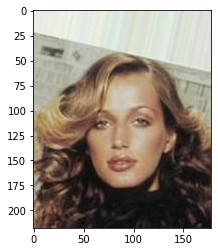

In [20]:
img = Image.open('/content/gdrive/MyDrive/Colab Notebooks/VMG/celebA_data/training_data/000190.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img)

#### Load training data

In [21]:
# Spatial size of training images, images are resized to this size.
image_size = 64
# batch size
batch_size = 64

transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                   std=[0.5, 0.5, 0.5])
                              ])


# Root directory for the dataset
data_root = '/content/gdrive/MyDrive/Colab Notebooks/VMG/celebA_data/temp'

train_dataset = ImageFolder(data_root, transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
print('Training samples: ', len(train_loader.dataset)) #Restricted size to 117 samples for making the code functional. It can be increased as desired.

Training samples:  117


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Start Training

In [22]:
total_batch = len(train_loader.dataset)//batch_size
max_epoch = 1

opt = torch.optim.Adam(CNN_Net(10).parameters(), lr=3e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(max_epoch):
    print("Epoch: ", epoch)
    for i, (image, labels) in enumerate(train_loader):
        # CNN paramters
        nfilters = np.array([32, 64, 128, 256, 512])
        nclass = 4 # 4 decoders
        #---------------------------- CNN -----------------------------------------
        print('-'*10 + ' Process: CNN ' + '-'*10)
        [lightingparameters,b,fmel,fblood,predictedShading,specmask] = CNN(image, 
                                                                        nfilters, 
                                                                        nclass, 
                                                                        LightVectorSize, 
                                                                        bSize)
        #------------------------  Scale Parameters -----------------------------
        print('-'*10 + ' Process: Scale Parameters ' + '-'*10)
        [weightA,weightD,CCT,Fweights,b,BGrid,fmel,fblood,predictedShading,specmask] = scalingNet(lightingparameters, 
                                                                                          b, 
                                                                                          fmel, 
                                                                                          fblood, 
                                                                                          predictedShading, 
                                                                                          specmask, 
                                                                                          bSize)
        print('Done...')
        #------------------------ Illumination Model ----------------------------
        print('-'*10 + ' Process: Illumination Model ' + '-'*10)
        # create the illumination model from CIE standard illuminants: A,D,F
        e = illuminationModel(weightA, weightD, Fweights, CCT, illumA, illumDNorm, illumFNorm)
        print('Done...')
        #------------------------ Camera Model ----------------------------------
        print('-'*10 + ' Process: Camera Model ' + '-'*10)
        [Sr,Sg,Sb] = cameraModel(mu, PC, b, wavelength)
        print('Done...')
        #------------------------ light colour ----------------------------------
        print('-'*10 + ' Process: Light Colour ' + '-'*10)
        lightcolour = computelightcolour(e, Sr, Sg, Sb)
        print('Done...')
        #------------------------ Specularities ---------------------------------
        print('-'*10 + ' Process: Specularities ' + '-'*10)
        Specularities = computeSpecularities(specmask, lightcolour)
        print('Done...')
        #---------------- Biophysical to spectral reflectance -------------------
        print('-'*10 + ' Process: Biophysical to spectral reflectance ' + '-'*10)
        R_total = BiotoSpectralRef(fmel,fblood,Newskincolour);
        print('Done...')
        #--------------------------- Image Formation ----------------------------
        print('-'*10 + ' Process: Image Formation ' + '-'*10)
        [rawAppearance, diffuseAlbedo] = ImageFormation(R_total, Sr,Sg,Sb,e,Specularities,predictedShading)
        print('Done...')
        #--------------------------- White Balance ------------------------------
        print('-'*10 + ' Process: White Balance ' + '-'*10)
        ImwhiteBalanced = WhiteBalance(rawAppearance,lightcolour)
        print('Done...')
        #------------------------ findT ------------------------------
        print('-'*10 + ' Process: findT ' + '-'*10)
        T_RAW2XYZ = findT(Tmatrix,BGrid)
        print('Done...')
#         #------------------------ from raw To sRGB ------------------------------
#         print('-'*10 + ' Process: from raw To sRGB ' + '-'*10)
#         sRGBim = fromRawTosRGB(ImwhiteBalanced,T_RAW2XYZ)
#         print('Done...')

#         scaleRGB = torch.mul(sRGBim, torch.float32(255))  
#         #scaleRGB.name ='scaleRGB';

#         # %scaleRGB = sRGBim;  scaleRGB.name ='scaleRGB';
#         Y1 = np.ones(muim.shape, dtype = np.float32)
#         Y1 = np.multiply(Y1, muim)
#         rgbim = ((scaleRGB) - Y1)

#         X1 = np.ones(size.shape,dtype = np.float32)
#         rgbim = np.multiply(rgbim, X1)
#         #rgbim.name = 'rgbim';

#         # Compute scale of the shading
#         scale = np.divide(np.sum(np.sum(np.multiply(np.multiply(actualshading, predictedShading), actualmasks), 0), 1),
#                         np.sum(np.sum(np.multiply(np.square(predictedShading),actualmasks), 0), 1))

#         predictedShading = np.multiply(predictedShading, scale)
#         alpha = np.multiply((actualshading - predictedShading), actualmasks)

#         #------------------------- LOSSES ---------------------------------------
#         # CNN weights
#         blossweight = 1e-4 
#         appweight = 1e-3
#         Shadingweight = 1e-5 
#         sparseweight = 1e-5 

#         # Camera parameter loss
#         priorB = np.sum(np.square(b[:]))  
#         #priorB.name ='priorB';
#         priorloss = np.multiply(priorB[:], blossweight) 
#         ZY = np.ones(priorloss.shape)
#         priorloss = np.multiply(priorloss, ZY)
#         #priorloss.name ='priorloss';
#         #----------------------
#         # L2: appearance loss
#         delta = np.multiply((images - rgbim), actualmasks)
#         appearanceloss = np.multiply(np.divide(np.sum(np.square(delta[:])), (224 * 224)), appweight)
#         Y = np.ones(appearanceloss.shape)
#         appearanceloss = np.multiply(appearanceloss, Y)
#         # appearanceloss.name ='appearanceloss';
#         #--------------------------
#         shadingloss = np.multiply(np.sum(np.square(alpha[:])), Shadingweight)
#         ff = np.ones(shadingloss.shape)
#         shadingloss = np.multiply(shadingloss, ff)
#         # shadingloss.name = 'shadingloss';
#         #----------------------
#         # L1 sparsity loss:
#         sparsityloss = np.multiply(np.sum(Specularities[:]), sparseweight)
#         J = np.ones(sparsityloss.shape)
#         sparsityloss = np.multiply(sparsityloss, J)
#         # sparsityloss.name = 'sparsityloss';

#         # Final Loss:
#         loss = appearanceloss + priorloss + sparsityloss + shadingloss
#         # loss.name= 'loss';
#         # loss.sequentialNames();

#         # Backprob + Optimize
#         d_loss = torch.tensor(0.5)
#         opt.zero_grad()
#         d_loss.backward()
#         opt.step()
# #         if(i+1)%log_step == 0:
# #             print("Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f"%(
# #             epoch, max_epoch, i+1, total_batch, d_loss.data[0], g_loss.data[0], real_score.data.mean(), fake_score.data.mean()))
        
# #         if(i+1)%sample_step == 0:
# #             fake_images = G(fixed_z)
# #             torchvision.utils.save_image(denorm(fake_images.data), os.path.join(SAMPLE_PATH, 'fake_samples-%d-%d.png')%(
# #             epoch+1, i+1), nrow=8)
            
# # torch.save(G.state_dict(), 'generator.pkl')
# # torch.save(D.state_dict(), 'discriminator.pkl')

Epoch:  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


---------- Process: CNN ----------
Process: fcn_multipleDecoders ...
Done ...
Process: CNN_Net ...
Done ...
Process: Getting parameters and predicted maps ...
Done ...
---------- Process: Scale Parameters ----------
Done...
---------- Process: Illumination Model ----------
Done...
---------- Process: Camera Model ----------
Done...
---------- Process: Light Colour ----------
Done...
---------- Process: Specularities ----------
Done...
---------- Process: Biophysical to spectral reflectance ----------
Done...
---------- Process: Image Formation ----------
Done...
---------- Process: White Balance ----------
Done...
---------- Process: findT ----------
Done...
